In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from pandas import DataFrame
import io
import json
import h5py
from scipy.signal import medfilt,find_peaks_cwt

sns.set_style("white")

In [2]:
'''defines glob object which has all of the files to be under data folder and have filepath of bigwig_intronic/huandy_ and then other.
'''
files = glob("data/intronic_conservation_bedgraphs/huandy_*")


In [46]:
'''Initialize the empty h5 file'''

with h5py.File('data/aggregate_regions_bp_resolution.h5', 'w') as h5file:

    '''For each bed file, read and append to the h5 collection'''
    for idx,f in enumerate(files):

        '''Log the current file # to keep track of progress'''
        if idx % 1000 == 0:
            print(idx, end= " ")

        region = pd.read_table(f,names=["chromosome","start","end","conservation"])
        
        '''Convert to correct datatypes'''
        region["start"] = region["start"].astype(int)
        region["end"] = region["end"].astype(int)
        region["conservation"] = region["conservation"].astype(float)

        '''Identify the region by the file name.
         -1 means taking the last element of each file path.'''
        region_id =f.split("/")[-1]
        
        '''Create separate datasets for start, end, and conservation'''
        
        starts = region["start"]
        ends = region["end"]
        conservations = region["conservation"]
        
        '''Expand conserved mini-regions into base-pair resolution array'''
        exploded_conservations = np.repeat(conservations,ends-starts)

        '''Input the base-pair resolution array into a new h5'''
        h5file.create_dataset(region_id,  data=exploded_conservations)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 

50
0 huandy_13035_chr1_78332076_78338688


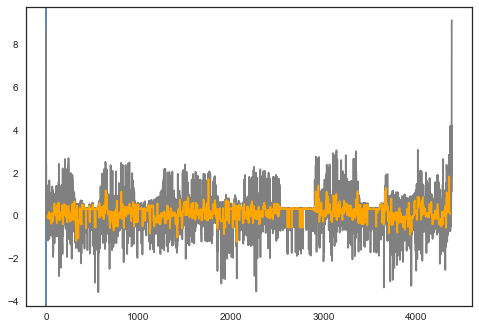

huandy_13035_chr3_126185168_126189737


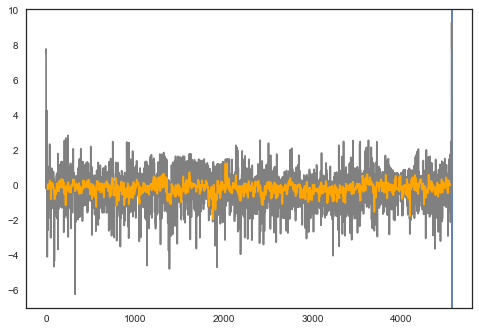

huandy_13035_chr3_130345391_130346162


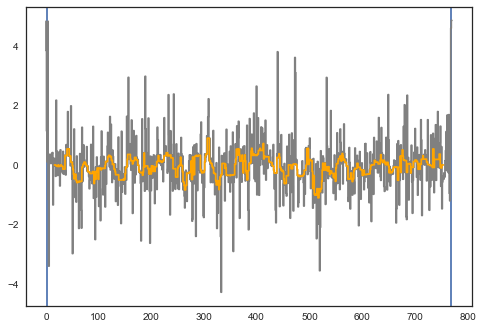

huandy_13035_chr5_115339077_115341608


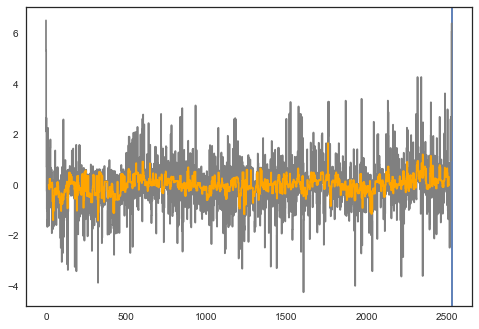

huandy_13035_chr15_50875353_50878588


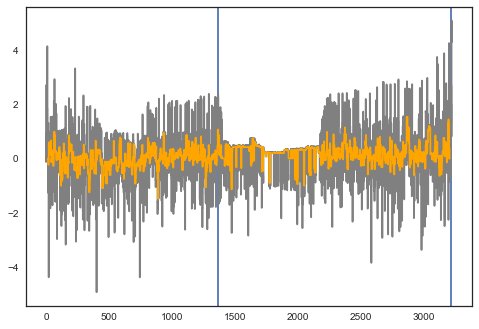

huandy_13035_chr11_67163871_67164649


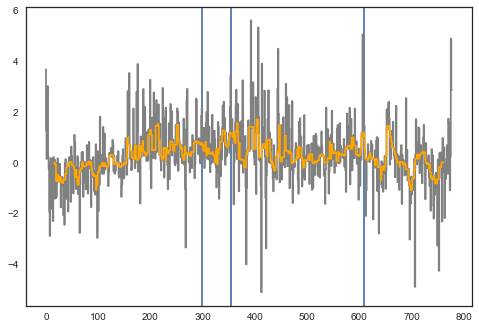

huandy_13035_chrX_53602748_53603859


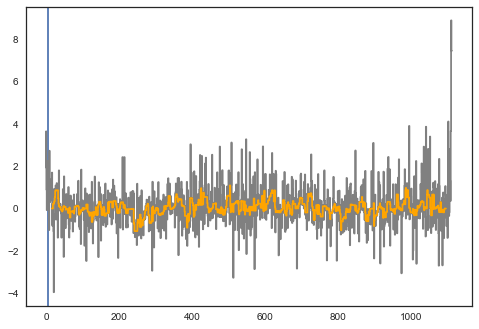

huandy_13035_chr1_109801701_109803663


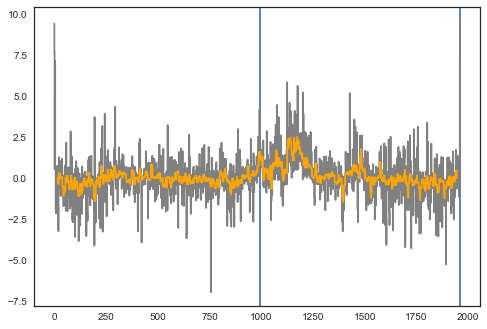

huandy_13035_chr11_68207384_68213903


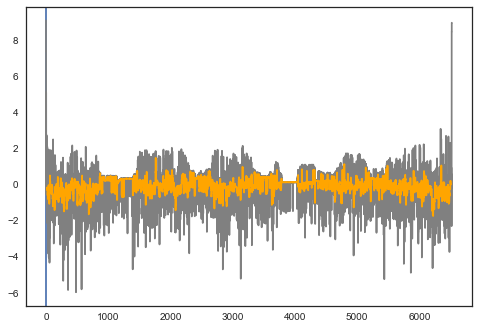

huandy_13035_chr22_41913635_41914484


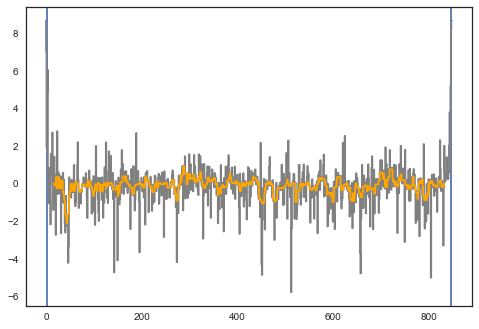

huandy_13035_chr2_157435676_157436201


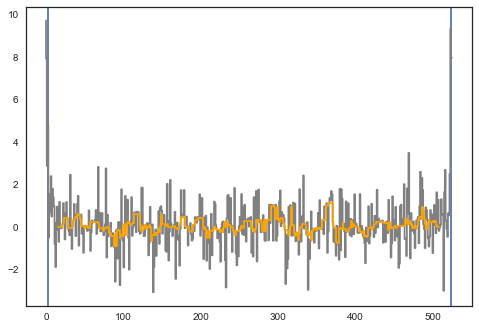

huandy_13035_chr6_7570796_7571615


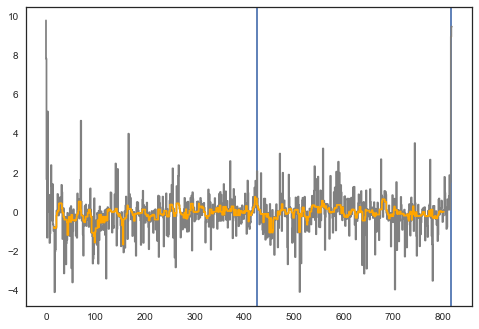

huandy_13035_chr5_145512644_145515163


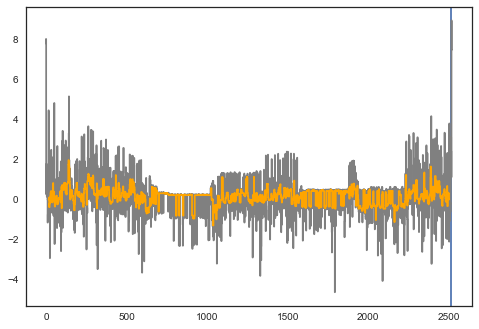

huandy_13035_chr19_55009478_55019105


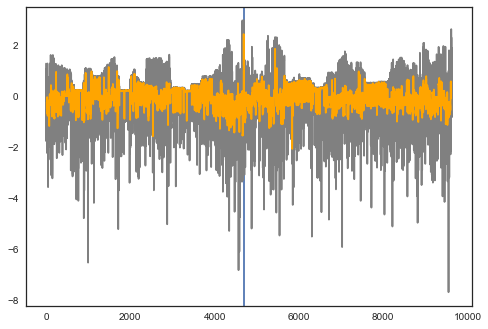

huandy_13035_chr20_36149805_36150759


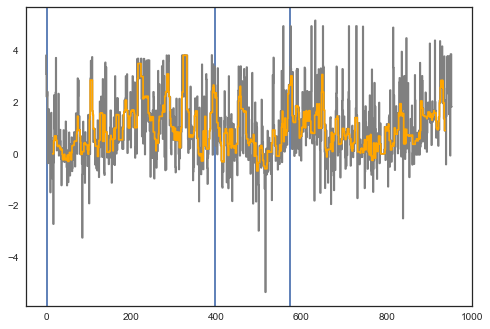

huandy_13035_chr3_57280250_57281422


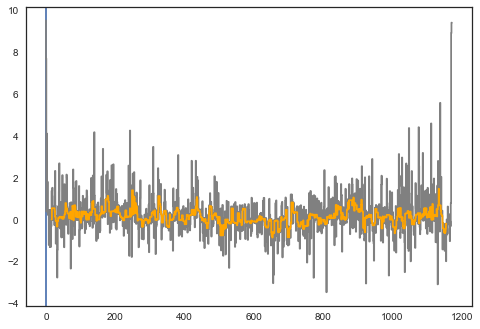

huandy_13035_chr11_118899544_118900101


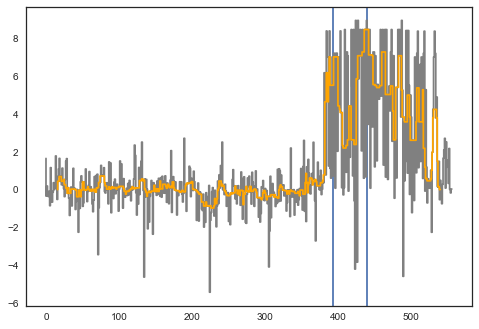

huandy_13035_chr6_105219949_105224615


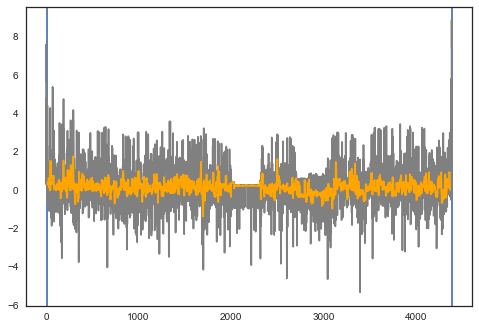

huandy_13035_chr9_125146034_125148724


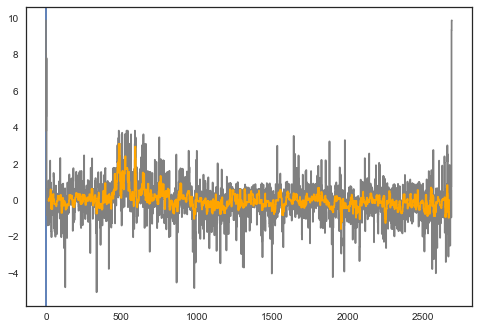

huandy_13035_chr4_128930346_128932827


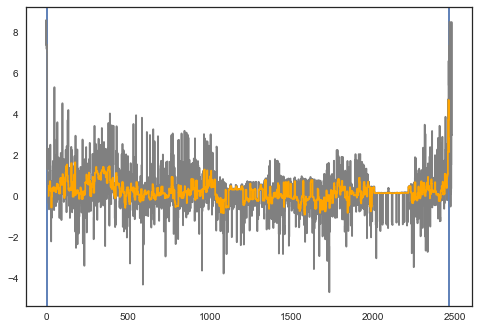

huandy_13035_chr5_139941580_139941684


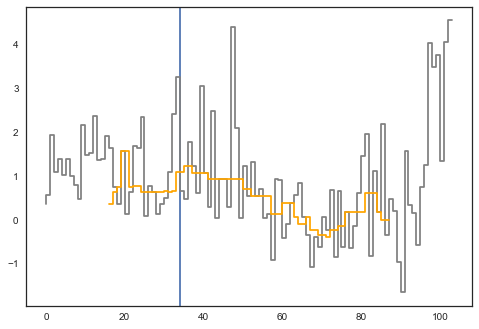

21


In [3]:
with h5py.File('data/aggregate_regions_bp_resolution.h5', 'r') as h5file:
    regions = list(h5file.keys())
    '''Define count'''
    count = 0
    
    peak_df = pd.DataFrame()
    peaks_files = []
    
    chroms = np.asarray([x.split("_")[-3] for x in regions])
    starts = np.asarray([int(x.split("_")[-2]) for x in regions])
    ends = np.asarray([int(x.split("_")[-1]) for x in regions])
    
#     select_regions = np.where((chroms == "chr3") & (starts>170582665) & (starts<170588045))

    select_regions = np.random.choice(len(regions),50)
#     select_regions = np.arange(len(regions))
    
    print(len(select_regions))
    
    region_lengths = []
    
    for idx,region in enumerate(np.asarray(regions)[select_regions]):
        
        if idx%100==0:
            print(idx,end=" ")
        
        conservation_scores = h5file[region][:]
        
        region_length = len(conservation_scores)
        if region_length < 10**4:
        

            window_width = 9

            if len(conservation_scores) > 32:

                running_median = medfilt(conservation_scores[16:-16],window_width)
                peaks = find_peaks_cwt(conservation_scores,np.arange(12,64),min_snr=2)

                if len(peaks) > 0:

                    peak_conservations = conservation_scores[peaks]
                    peaks = peaks[peak_conservations > 2]

                    if len(peaks) > 0 and len(peaks) < 4:
                        count+=1

                        for bp in peaks:
                            plt.axvline(bp)

                        plt.step(np.arange(len(conservation_scores)),conservation_scores,c="grey")
                        plt.step(np.arange(len(running_median))+16,running_median,c="orange")
                        print(region)
                        plt.show()

                        peaks_files.append(region)
                        
    print(len(peaks_files))

    peak_df["file_region"] = peaks_files
    peak_df.to_csv("peak_df.csv")

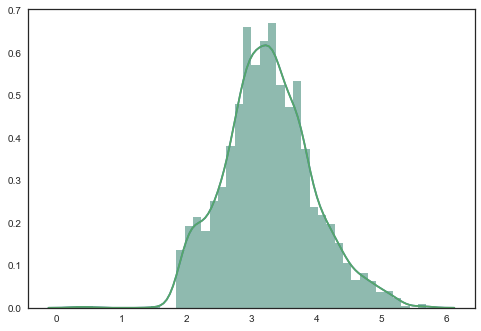

In [30]:
sns.distplot(np.log10(region_lengths))
plt.show()

In [22]:
for idx,f in enumerate(files[:1000]):
    
    if idx % 100 == 0:
        print(idx, end= " ")
    
    region_id =f.split("/")[-1]

    region = pd.read_hdf('data/aggregate_regions.h5',key=region_id)

0 100 200 300 400 500 600 700 800 900 

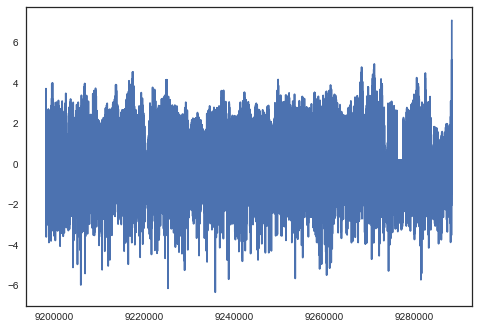

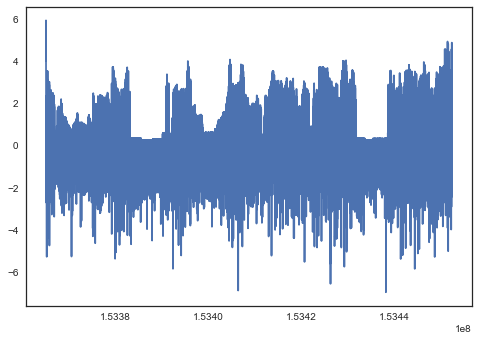

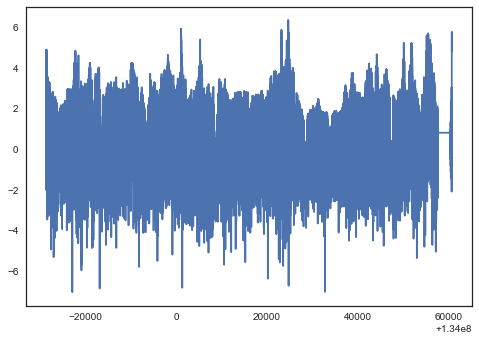

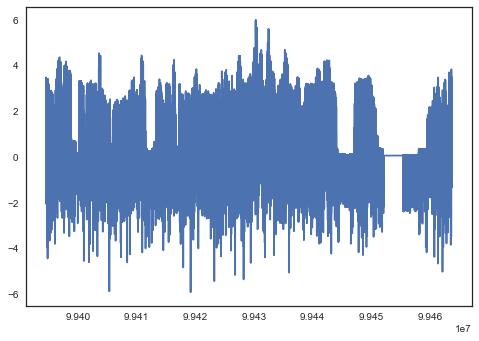

KeyboardInterrupt: 

In [4]:

hcc_dict = dict()
'''loop through each file in glob object files and read its columns into table named region. 
Then take the ones with conservation greater than 0.75 and move into hcc.'''
for f in files:
    region = pd.read_table(f,names=["chromosome","start","end","conservation"])
    hcc = region.conservation >= 0.75
    '''convert table hcc into a list'''
    hcc_list= hcc.tolist()
    '''Identify peaks by counting how many base pairs in each region with conservation score greater than 0.75'''
    y = hcc_list.count(True)
    '''Then output the regions with more than 1000 of the peaks into a dictionary '''
    if y >= 10000:
        hcc_dict[f] = y
        plt.step(region["start"],region["conservation"])
        plt.show()
'''Write output of dictionary into a local file'''
with open('hcc_dict_output.txt', 'w') as file:
     file.write(json.dumps(hcc_dict))